
# A Life Cycle Model: Data and Theory

National registry data on income and wealth from Scandinavian countries (esp. Norway) have recently become available (with a lot of security) to some (lucky!) researchers.   These data offer a uniquely powerful tool for testing (and improving) our models of consumption and saving behavior over the life cycle.

This notebook is an example of how to construct a life cycle model with the HARK toolkit that makes predictions that can be compared to the raw data statistics that now are becoming available.

For example, existing papers have tabulated information about the **growth rate** of assets at different ages over the life cycle. 

The default parameters of the HARK life cycle model have not been optmized to match features of the Norwegian data; a first step in a real "structural" estimation would be to use Norwegian calibrate the inputs to the model (like the profile of income, and the magnitude of income shocks, over the life cycle), and then to find the values of parameters like the time preference rate that allow the model to fit the data best.  (See [SolvingMicroDSOPs](https://econ.jhu.edu/people/ccarroll/SolvingMicroDSOPs) for how this can be done, and search for the corresponding HARK content using [our documentation](https://hark.readthedocs.io)).

In [1]:
# Initial imports and notebook setup, click arrow to show

import HARK.ConsumptionSaving.ConsIndShockModel as cShksModl        # The consumption-saving micro model
import HARK.SolvingMicroDSOPs.Calibration.EstimationParameters as Params    # Parameters for the consumer type and the estimation
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools
import pandas as pd 

import numpy as np

***NOTE: using a 'quick fix' for an attribute error. See 'Error Notes' in EstimationParameter.py for further discussion.***


In [2]:
# Set up default values for CRRA, DiscFac, and simulation variables in the dictionary 
Params.init_consumer_objects["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_consumer_objects["DiscFac"]= 0.97         # Default intertemporal discount factor (beta)
Params.init_consumer_objects["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_consumer_objects["aNrmInitMean"]= -10.0   # Mean of log initial assets 
Params.init_consumer_objects["aNrmInitStd"]= 1.0      # Standard deviation of log initial assets
Params.init_consumer_objects["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_consumer_objects["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

In [3]:
# Make an instance of a lifecycle consumer to be used for estimation
LifeCyclePop = cShksModl.IndShockConsumerType(**Params.init_consumer_objects)

In [4]:
# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpackcFunc()                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrmNow','pLvlNow','mNrmNow','cNrmNow','TranShkNow']

LifeCyclePop.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()                         # Simulate a population behaving according to this model

C:\Users\taaur\Anaconda3\lib\site-packages\HARK\interpolation.py:1710: RuntimeWarning: All-NaN slice encountered
  y = np.nanmin(fx,axis=1)


Consumption as a function of market resources while working:


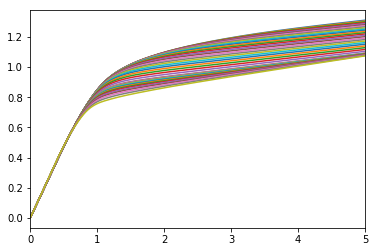

In [5]:
# Plot the consumption functions during working life

print('Consumption as a function of market resources while working:')
mMin = min([LifeCyclePop.solution[t].mNrmMin for t in range(LifeCyclePop.T_cycle)])
plotFuncs(LifeCyclePop.cFunc[:LifeCyclePop.T_retire],mMin,5)

In [6]:
# Define the saving rate function
def savRteFunc(SomeType, m, t):
    """
    Parameters:
    ----------
        SomeType: 
             Agent type that has been solved and simulated.
        m:
            normalized market resources of agent
        t:
            age of agent (from starting in the workforce)
        
        
    Returns:
    --------
        savRte: float
    
    """
    inc = (SomeType.Rfree -1.)*(m-1.)+1. # Normalized by permanent labor income
    cns = SomeType.solution[t].cFunc(m)  # Consumption (normalized)
    sav = inc - cns                      # Flow of saving this period
    savRte = sav / inc                   # Saving Rate
    return savRte  

In [7]:
# Create a giant matrix gathering useful data:
# 't_now', 'aNrmNow_hist', 'cNrmNow_hist', employment-status in date t and date t-1,
# aLvlGro_hist, Saving rate

w, h = 1, LifeCyclePop.T_cycle
giant_list = [[0 for x in range(w)] for y in range(h)]
savRte_list = []

import warnings
warnings.filterwarnings("ignore") # Suppress some disturbing but harmless warnings

for t in range(1,LifeCyclePop.T_cycle+1):
    #aLvlGro_hist[0] = 0 # set the first growth rate to 0, since there is no data for period 0
    aLvlGroNow = np.log((LifeCyclePop.aNrmNow_hist[t]   *LifeCyclePop.pLvlNow_hist[t])/ \
                         LifeCyclePop.aNrmNow_hist[t-1] *LifeCyclePop.pLvlNow_hist[t-1]) # (10000,)

    # Call the saving rate function defined above 
    savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
      
    savRte_list.append(savRte) # Add this period's saving rate to the list 

    # Create elements of matrix list
    matrix_list = [0 for number in range(7)]
    matrix_list[0] = t
    matrix_list[1] = LifeCyclePop.aNrmNow_hist[t]
    matrix_list[2] = LifeCyclePop.cNrmNow_hist[t]
    matrix_list[3] = LifeCyclePop.TranShkNow_hist[t]
    matrix_list[4] = LifeCyclePop.TranShkNow_hist[t-1]
    matrix_list[5] = aLvlGroNow
    matrix_list[6] = savRte
    
    giant_list[t-1] = matrix_list

In [8]:
# Construct the level of assets A from a*p where a is the ratio to permanent income p
# Remember 41 is "years after entering workforce" (=age 25); 66 is the year right after retirement
LifeCyclePop.aLvlNow_hist = LifeCyclePop.aNrmNow_hist*LifeCyclePop.pLvlNow_hist
aGro41=LifeCyclePop.aLvlNow_hist[41]/LifeCyclePop.aLvlNow_hist[40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers; don't want growth rates relative to 0 income!

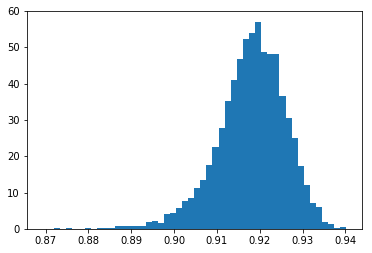

In [9]:
# Plot the (truncated) distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
from matplotlib import pyplot as plt
n, bins, patches = plt.hist(aGro41NoU,50,density=True)

# PROBLEM : Distribution of aNrm and aLev

Perhaps more interesting than the distribution of asset growth rates over the life cycle is the distribution of the level of assets, or the ratio of assets to permanent income.

Construct a plot similar to the one above for the disributions of $\texttt{aNrm}$ and $\texttt{aLev}$ in the period just BEFORE retirement (44 periods from the start).


In [10]:
# put your solution here

Text(0.5, 1.0, 'Distribution of Asset Levels')

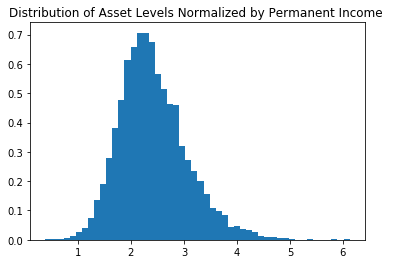

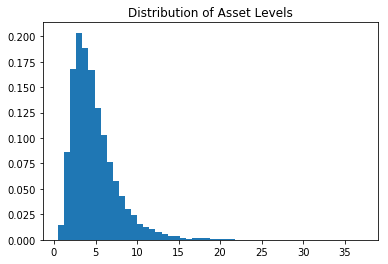

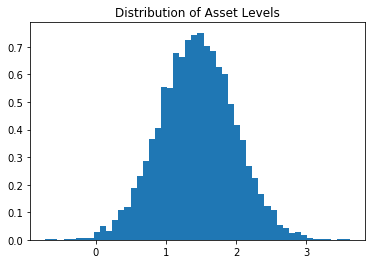

In [11]:
# SOLUTION :  
# First a histogram for asset levels normalized by permanant income
n, bins, patches = plt.hist(LifeCyclePop.aNrmNow_hist[39],50,density=True)
plt.title("Distribution of Asset Levels Normalized by Permanent Income ")

# Now a histogram for asset levels
plt.figure()
n, bins, patches = plt.hist(LifeCyclePop.aLvlNow_hist[39],50,density=True)
plt.title("Distribution of Asset Levels")

# For good measure, do logs too
plt.figure()
n, bins, patches = plt.hist(np.log(LifeCyclePop.aLvlNow_hist[39]),50,density=True)
plt.title("Distribution of Asset Levels")

# PROBLEM : "Luck" and Saving

In this model, each consumer experiences a set of draws of permanent income shocks over their lifetime.  Some will be lucky and draw a mostly positive series of shocks (and unlucky people experience negative shocks).

This problem asks you to examine the consequences of these shocks for the lifetime pattern of saving.

The first step is to recalibrate the model so that there is no difference in initial assets, then reconstruct the initial conditions and simulate the model:

In [12]:
# put your answer here

In [13]:
# SOLUTION
# Set up values for simulation parameters in the dictionary 
Params.init_consumer_objects["aNrmInitStd"]= 0.0      # Standard deviation of log initial assets

LifeCyclePop = cShksModl.IndShockConsumerType(**Params.init_consumer_objects)

# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpackcFunc()                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrmNow','pLvlNow','mNrmNow','cNrmNow','TranShkNow','pLvlNow']

LifeCyclePop.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()                         # Simulate a population behaving according to this model

# PROBLEM : "Luck" and Saving (cont)

Now we are interested in comparing the people who were "lucky" vs those who were "unlucky"

The easiest way to measure this is by the cumulated level of noncapital (labor) income they have experienced over their working life.

For consumer in period 41 (age 66), calculate this object, then plot it against the $\texttt{aNrm}$ ratio at age 66.

In [14]:
# put your answer here

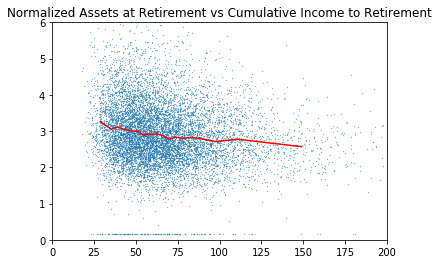

In [15]:
# SOLUTION
income_history = LifeCyclePop.pLvlNow_hist*LifeCyclePop.TranShkNow_hist
cumulative_income_to_retirement = np.sum(income_history[0:41,:],0)
plt.scatter(cumulative_income_to_retirement,LifeCyclePop.aNrmNow_hist[41],s=0.05)
plt.title("Normalized Assets at Retirement vs Cumulative Income to Retirement")
plt.xlim(0,200)
plt.ylim(0,6)
# add a trend line in red
vigntiles = pd.qcut(cumulative_income_to_retirement,20,labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
assetsNrmVigtile = np.zeros(20)
meanVigntile = np.zeros(20)
for i in range(20):
    assetsNrmVigtile[i] = np.mean(LifeCyclePop.aNrmNow_hist[41][vigntiles==i])
    meanVigntile[i] = np.mean(cumulative_income_to_retirement[vigntiles==i])
#plt.figure()
plt.plot(meanVigntile, assetsNrmVigtile,color='r')

# PROBLEM : "Luck" and Saving (cont)

You can have luck in transitory income shocks or in permanent income shocks.  Their consequences are quite different.  With a permanent shock, you expect your (noncapital) income to change forever, and (according to Friedman (1957)) you should adjust your consumption nearly one-for-one.  With a transitory shock, you expect your income to return to its "permanent" level so you do not consume. So if you get a positive transitory shock, you will mostly save it.

The existence of transitory shocks therefore means that people who have on average experienced positive transitory shocks over their lifetimes should have higher saving rates.  That would bias the relationship between lifetime income and the $\texttt{aNrm}$ ratio upward.

To see how important this might be, redo the same exercise as before, but using the level of (noncapital) permanent income (rather than overall income including transitory and permanent) over the lifetime.  Comment on the result

In [16]:
# put your solution here

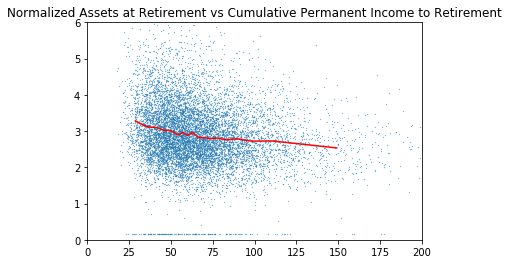

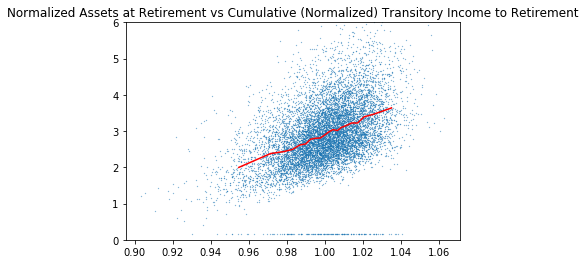

In [17]:
# SOLUTION
cumulative_perm_income_to_retirement = np.sum(LifeCyclePop.pLvlNow_hist[0:41,:],0)
plt.scatter(cumulative_perm_income_to_retirement,LifeCyclePop.aNrmNow_hist[41],s=0.05)
plt.xlim(0,200)
plt.ylim(0,6)
plt.title("Normalized Assets at Retirement vs Cumulative Permanent Income to Retirement")
# add a trend line in red
vigntiles = pd.qcut(cumulative_perm_income_to_retirement,20,labels=False)
assetsNrmVigtile = np.zeros(20)
meanVigntile = np.zeros(20)
for i in range(20):
    assetsNrmVigtile[i] = np.mean(LifeCyclePop.aNrmNow_hist[41][vigntiles==i])
    meanVigntile[i] = np.mean(cumulative_perm_income_to_retirement[vigntiles==i])
#plt.figure()
plt.plot(meanVigntile, assetsNrmVigtile,color='r')

#It may also be interesting to see the relationship with cumulative transitory income
plt.figure()
cumulative_tran_income_to_retirement = np.sum(LifeCyclePop.TranShkNow_hist[0:41,:]*LifeCyclePop.pLvlNow_hist[0:41,:],0) \
                                        /np.sum(LifeCyclePop.pLvlNow_hist[0:41,:],0)
plt.scatter(cumulative_tran_income_to_retirement,LifeCyclePop.aNrmNow_hist[41],s=0.05)
plt.ylim(0,6)
plt.title("Normalized Assets at Retirement vs Cumulative (Normalized) Transitory Income to Retirement")
# add a trend line in red
vigntiles = pd.qcut(cumulative_tran_income_to_retirement,20,labels=False)
assetsNrmVigtile = np.zeros(20)
meanVigntile = np.zeros(20)
for i in range(20):
    assetsNrmVigtile[i] = np.mean(LifeCyclePop.aNrmNow_hist[41][vigntiles==i])
    meanVigntile[i] = np.mean(cumulative_tran_income_to_retirement[vigntiles==i])
#plt.figure()
plt.plot(meanVigntile, assetsNrmVigtile,color='r')

# SOLUTION : Comment

The second figure shows the phenomenon mentioned in the statement of the problem: People who have experienced higher levels of transitory shocks over their lifetimes will have saved more, because on average they (correctly) expected those shocks to reverse themselves.  However, among the lucky people who happened to experience a whole lifetime in which they had a higher-than-average amount of transitory shocks, will have ended up saving more.  The lifetime average size of the transitory shock is 1.00, and most people end up with an average value between 0.96 and 1.04.  

Suppose that, at an interest rate of zero, you were to save 40 years' worth of transitory shocks worth 0.04 each year (that is, you had a n MPC out of the transitory shocks of zero).  This would cumulate to $40*0.04=1.60$ years of extra assets at retirement - roughly the amount by which the figure shows people ending up with an average transitory shock of 1.04 have assets that exceed those of people with an average transitory shock of 1.0

However, the first figure shows that there is a strong downward slope to the relationship between the average _total_ amount of lifetime income and normalized assets at retirement.  When someone with assets $a_{t}=A_{t}/P_{t}$ experiences a positive shock $\psi_{t+1} > 1$, the immediate effect is to _reduce_ $b_{t+1} = (B_{t+1}/P_{t+1})R$.  As a result $c_{t+1}$ is lower and the _flow_ saving _rate_ is higher.  To see the logic, think of someone who ended period $t$ with their target $b_{t} = \check{b}$, so that if they had ended up with $m_{t+1} = \mathbb{E}_{t}[\check{b}_{t+1}]+1$ they would have expected to consume the amount $\check{c}_{t+1}$ that would leave $a_{t+1}=\check{a}$.  However, they end up with a lower value of $b_{t+1}$ and therefore a lower value of $m_{t+1}$.  We know that consumers with $m < \check{m}$ are net savers because they are trying to build their $m$ (equivalently, $a$ and $b$) back up to their target level.  

More concretely: suppose the consumer has values of end-of-period assets $A_{t}$ and permanent inccome $P_{t}$ such that $a_{t} (\equiv A_{t}/P_{t}) = \check{a}$ where $\check{a}$ is the value such that $\mathbb{E}_{t}[b_{t+1}]=\check{b}$.  Since their period $t+1$ saving rate was expected to be essentially zero at $\mathbb{E}_{t}[R A_{t}/\psi_{t+1}] = b_{t+1} = \check{b}$, if they instead end up with a value of $\psi_{t+1}$ much greater than its mean value of $\mathbb{E}_{t}[\psi_{t+1}]=1$, they will be at a $b_{t+1} < \check{b}$.  They are below their target $b$ and thus expected to save a positive amount instead of zero.

# PROBLEM : Saving Rates and Wealth Ratios

The [Haig-Simons definition of "saving"](https://en.wikipedia.org/wiki/Haig%E2%80%93Simons_income) is basically the amount by which your wealth changes from one period to the next. This definition includes the consequences of any capital gains (or losses) for your wealth.  

In recent work, [Faegering, Holm, Natvik, and Moll](http://www.nber.org/papers/w26588) have proposed that instead households largely ignore the consequences of capital gains and losses.  That is, their consumption is largely unchanged by asset price movements.

Specifically, they define "active saving" as the difference between income and consumption _neglecting_ any contriubutions from "buy and hold" assets like houses or stocks.  The "active saving rate" is the quantity of active saving divided by the level of income. They find that the "active saving rate" is remarkably stable over the range from roughly the 20th percentile to the 95th percentile of the wealth distribution (see the figures below from their paper).

The basic model considered above does not allow for capital gains or losses, so it can be used to calculate directly the saving behavior of people who do not anticipate capital gains and losses.  So, the saving rate computed by the $\texttt{savRte}$ function above should correspond to their "active saving rate."

Your problem: For the entire population simulated above, calculate what the model predicts about the saving rate they measure.  You will do this by grouping the population into vigntile bins, and calculating the average active saving rate for all the households in each vigntile, and then plotting the wealth vigntiles against their saving rates.

![fbbn-sav-by-age-and-ed.jpg](https://github.com/llorracc/Figures/blob/master/fbbn-sav-by-age-and-ed.jpg?raw=true)


In [18]:
# put your solution here

Text(0, 0.5, 'Saving Rate')

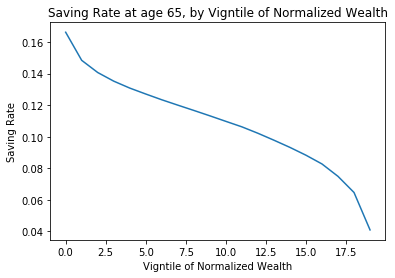

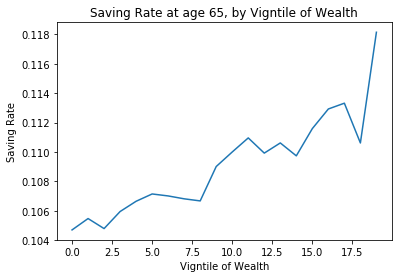

In [19]:
#SOLUTION
from pandas import qcut 
t=39  #Age from joining workforce to consider
# First do by normalized assets
LifeCyclePop.aLvlNow_hist = LifeCyclePop.aNrmNow_hist*LifeCyclePop.pLvlNow_hist
vigntiles = qcut(LifeCyclePop.aNrmNow_hist[t],20,labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
savRteByVigtile = np.zeros(20)
for i in range(20):
    savRteByVigtile[i] = np.mean(savRte[vigntiles==i])
plt.plot(np.array(range(20)), savRteByVigtile)
plt.title("Saving Rate at age 65, by Vigntile of Normalized Wealth")
plt.xlabel("Vigntile of Normalized Wealth")
plt.ylabel("Saving Rate")# corrected "savings rate": I thought I had indoctrinated you on that usage!

# Next do by assets (not normalized)
plt.figure()
LifeCyclePop.aLvlNow_hist = LifeCyclePop.aNrmNow_hist*LifeCyclePop.pLvlNow_hist
vigntiles = qcut(LifeCyclePop.aLvlNow_hist[t],20,labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
savRteByVigtile = np.zeros(20)
for i in range(20):
    savRteByVigtile[i] = np.mean(savRte[vigntiles==i])
plt.plot(np.array(range(20)), savRteByVigtile)
plt.title("Saving Rate at age 65, by Vigntile of Wealth")
plt.xlabel("Vigntile of Wealth")
plt.ylabel("Saving Rate") 

# Saving Rates and Lifetime Income Growth

We are interested in how income growth over the lifetime of the agent affects their saving rate and asset ratio $a=A/P$.


Text(0, 0.5, 'Normalized Assets')

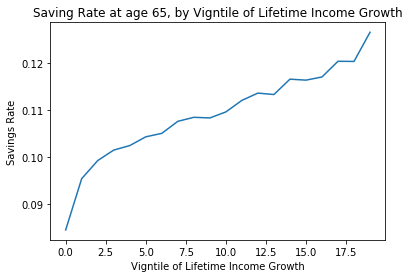

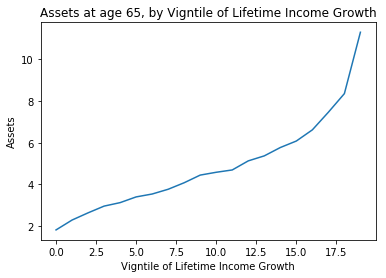

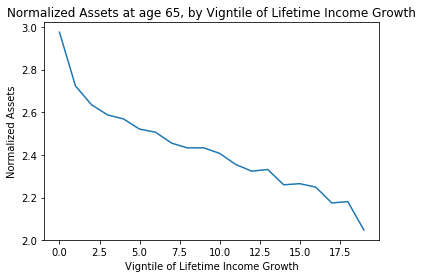

In [20]:
cumulative_income_first_half = np.sum(LifeCyclePop.pLvlNow_hist[0:20,:]*LifeCyclePop.TranShkNow_hist[0:20,:],0)
cumulative_income_second_half = np.sum(LifeCyclePop.pLvlNow_hist[20:40,:]*LifeCyclePop.TranShkNow_hist[20:40,:],0)
lifetime_growth = cumulative_income_second_half/cumulative_income_first_half

t=39
vigntiles = pd.qcut(lifetime_growth,20,labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
savRtgueseByVigtile = np.zeros(20)
assetsByVigtile = np.zeros(20)
assetsNrmByVigtile = np.zeros(20)
savRteByVigtile = np.zeros(20)
for i in range(20):
    savRteByVigtile[i] = np.mean(savRte[vigntiles==i])
    assetsByVigtile[i] = np.mean(LifeCyclePop.aLvlNow_hist[t][vigntiles==i])
    assetsNrmByVigtile[i] = np.mean(LifeCyclePop.aNrmNow_hist[t][vigntiles==i])
plt.plot(np.array(range(20)), savRteByVigtile)
plt.title("Saving Rate at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Savings Rate")

plt.figure()
plt.plot(np.array(range(20)), assetsByVigtile)
plt.title("Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Assets")

plt.figure()
plt.plot(np.array(range(20)), assetsNrmByVigtile)
plt.title("Normalized Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Normalized Assets")

# SOLUTION : Comment

How could the model's predictions be compared with empirical data, for example from the Norwegian registry?

One way would be to calibrate the model so that it is matches the distribution of wealth in Norway in the last few years when data are available (as long as those are years where nothing particularly surprising was going on in Norway).

Using the kinds of techniques in [The Distribution of Wealth and the MPC](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC) we can calibrate the life cycle model such that it does the best job it can to match the empirical data.  (This would also require recalibration of the model's inputs to Norwegian data, for example on the magnitude of transitory and permanent shocks to income).  Then we could calculate, in the model and in the data, the kinds of statistics captured in the figures above (constructed with a U.S. calibration).  
